# Following DataQuest project - Portfolio Project: Predicting Stock Prices Using Pandas and Scikit-learn by Vik Paruchuri

Recall (sensitivity) = Ceux qui sont vraiment positifs (TP/Total positif)  -- > Relevant instances  
Precision = Nombre de positif trouvé parmis les vrais et faux positifs (TP/TP+FP)

**Ticker** represents the stock symbol and has many functions  
**History**: Retrieves historical price data for the stock -- > Renvoie un **Dataframe**  
**Dividends**: Shows the dividend payouts over time.  
**Splits**: Lists stock splits.  
**Actions**: Combines dividends and splits.  
**Info**: Returns a dictionary with fundamental data like market cap, P/E ratio, etc.  
**Financials**: Retrieves the financial statements (income statement, balance sheet).  
**Recommendations**: Displays analyst recommendations for the stock.  

Un danger les price prediction est d'avoir un modèle qui utilise ses propres données pour se prédir, ce qui donnerait une très bonne précision mais aucun intérêt dans le monde réel car on aura pas les données du jour J pour prédire le jour J  
    -- > **Shift data, explicit predictors (séparés de la Target)**


In [312]:
import pandas as pd
import os
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

# Data Manipulation

Save the data to disk, so we can access it again if we need it without calling the API over and over

In [313]:
microsoft_path = "msft_data.json"

if os.path.exists(microsoft_path):
    with open(microsoft_path):
        microsoft_history = pd.read_json(microsoft_path)
else :
    stock_microsoft = yf.Ticker("MSFT")
    microsoft_history = stock_microsoft.history(period="max")
    #Save
    microsoft_history.to_json(microsoft_path)
microsoft_history.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13 05:00:00,0.054594,0.062623,0.054594,0.059946,1031788800,0.0,0.0
1986-03-14 05:00:00,0.059946,0.063158,0.059946,0.062087,308160000,0.0,0.0
1986-03-17 05:00:00,0.062087,0.063694,0.062087,0.063158,133171200,0.0,0.0
1986-03-18 05:00:00,0.063158,0.063694,0.061017,0.061552,67766400,0.0,0.0
1986-03-19 05:00:00,0.061552,0.062087,0.059946,0.060482,47894400,0.0,0.0


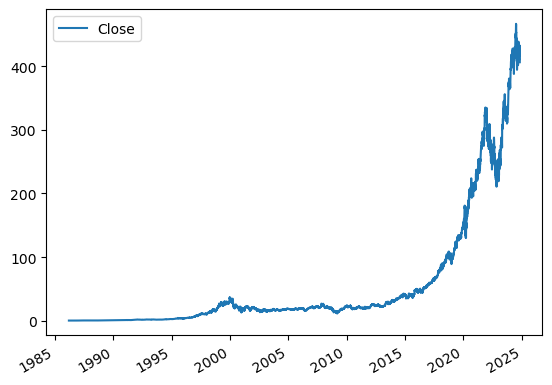

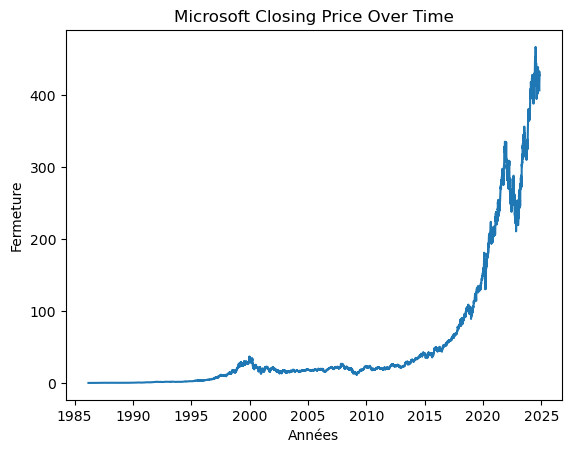

In [314]:
# Affichage du contenu
microsoft_history.plot.line(y="Close", use_index=True)
#microsoft_history.plot(y="Volume", x="High", kind="line")

#Eviter figures se mélangent 
plt.figure()

plt.plot(microsoft_history.index, microsoft_history["Close"])
plt.xlabel("Années")
plt.ylabel("Fermeture")
plt.title("Microsoft Closing Price Over Time")
plt.show()

Utilisation **iloc[]** pour l'accès aux indices  
Initialisation avec **np.nan** plutot que 0

In [315]:
# Création nouveau DF qui dit si on a cloturé positif ou non 
data = microsoft_history[["Close"]]    # Conserve format DF grâce au double crochet, sinon on aurait que la série Close
data = data.rename(columns = {'Close':'Actual_Close'})
data["Target"] = np.nan     

""" Eviter d'aller chercher directement DF -- > UTILISATION ILOC[]
for acc in range(1, len(microsoft_history)):
    if microsoft_history["Close"][acc] > microsoft_history["Close"][acc-1]:
        data["Target"][acc-1]=1  
    else:
        data["Target"][acc-1]=0
    acc+=1 """

#Version avec iloc fonctionnelle 
for i in range(1, len(microsoft_history)):
    if microsoft_history["Close"].iloc[i] > microsoft_history["Close"].iloc[i - 1]:
        data["Target"].iloc[i] = 1
    else:
        data["Target"].iloc[i] = 0
data.head(5)

,Actual_Close,Target
1986-03-13 05:00:00,0.059946,NaN
1986-03-14 05:00:00,0.062087,1.0
1986-03-17 05:00:00,0.063158,1.0
1986-03-18 05:00:00,0.061552,0.0
1986-03-19 05:00:00,0.060482,0.0


Utiliser **np.where** pour travailler plus efficacement sur les tableaux (version **vectorisé**)

In [316]:
data["Cloture"]=np.where(data["Target"]==1, "Positive", "Négative")
data.head(5)

,Actual_Close,Target,Cloture
1986-03-13 05:00:00,0.059946,NaN,Négative
1986-03-14 05:00:00,0.062087,1.0,Positive
1986-03-17 05:00:00,0.063158,1.0,Positive
1986-03-18 05:00:00,0.061552,0.0,Négative
1986-03-19 05:00:00,0.060482,0.0,Négative


Next, we'll **shift the data from previous days "forward" one day**, so we can use it to predict the target price. This ensures that we don't accidentally use data from the same day to make predictions! (a very common mistake)

In [317]:
shifted_microsoft = microsoft_history.copy()
shifted_microsoft = shifted_microsoft.shift(1)
shifted_microsoft.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14 05:00:00,0.054594,0.062623,0.054594,0.059946,1.031789e+09,0.0,0.0
1986-03-17 05:00:00,0.059946,0.063158,0.059946,0.062087,3.081600e+08,0.0,0.0
1986-03-18 05:00:00,0.062087,0.063694,0.062087,0.063158,1.331712e+08,0.0,0.0
1986-03-19 05:00:00,0.063158,0.063694,0.061017,0.061552,6.776640e+07,0.0,0.0


In [318]:
# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(shifted_microsoft[predictors]).iloc[1:]
data.head()

,Actual_Close,Target,Cloture,Close,Volume,Open,High,Low
1986-03-14 05:00:00,0.062087,1.0,Positive,0.059946,1.031789e+09,0.054594,0.062623,0.054594
1986-03-17 05:00:00,0.063158,1.0,Positive,0.062087,3.081600e+08,0.059946,0.063158,0.059946
1986-03-18 05:00:00,0.061552,0.0,Négative,0.063158,1.331712e+08,0.062087,0.063694,0.062087
1986-03-19 05:00:00,0.060482,0.0,Négative,0.061552,6.776640e+07,0.063158,0.063694,0.061017
1986-03-20 05:00:00,0.058876,0.0,Négative,0.060482,4.789440e+07,0.061552,0.062087,0.059946


**IMPORTANT**  
    Stock price data is inherently sequential. The price at any given time is influenced by prior prices, making it crucial to maintain the temporal order when creating predictions  
-- > On va pas split en Entrainement/Test de manière random mais séquentiel !! Et après random forest youpi  
    -- > Evite **Data Leakage**  

    Pas oublier de Copier data !
      

# Model

In [319]:
# Parameters
n_estimators=100 
min_samples_split=200

# Data sets
train = data.iloc[:-100].copy()
test = data.iloc[-100:].copy()

In [320]:
# Model
model = RandomForestClassifier(n_estimators=n_estimators, min_samples_split=min_samples_split, random_state=42)
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=42)

In [321]:
prediction = model.predict(test[predictors])
prediction = pd.Series(prediction, index=test.index) # Converti en série 
precision_score(test["Target"], prediction)

0.7142857142857143

<Axes: >

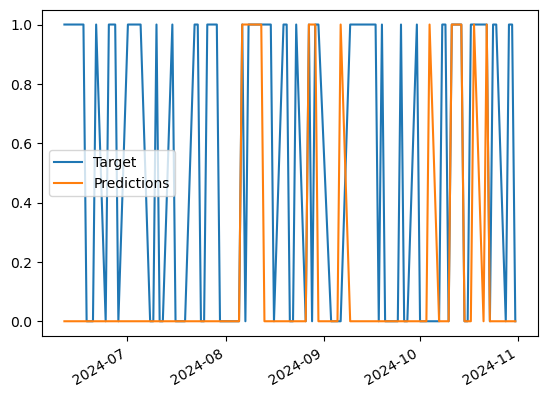

In [322]:
combined = pd.concat({"Target": test["Target"],"Predictions": prediction}, axis=1)
combined.plot()

On veut un code plus safe -- > On va récupérer les probas de la forêt et augmenter le **threshold** naturellement de 0.5 à genre 0.6  
On utilise **predict_proba** qui renvoie un tableau avec la proba de chaque scénario (ici 0 ou 1 donc 2 colonnes)

In [323]:
predi = model.predict_proba(test[predictors])[:,1]
predi = np.where(predi > 0.6, 1, 0)
predi = pd.Series(predi, index=test.index)
predi.head()

2024-06-11 04:00:00    0
2024-06-12 04:00:00    0
2024-06-13 04:00:00    0
2024-06-14 04:00:00    0
2024-06-17 04:00:00    0
dtype: int32

Loop pour avoir travailler sur plus de données

In [324]:
predictions = []
step = 2000

for i in range(1000, len(data), step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()

    model.fit(train[predictors], train["Target"])
    predi = model.predict_proba(test[predictors])[:,1]
    predi = np.where(predi > 0.6, 1, 0)
    predi = pd.Series(predi, index=test.index)

    combined = pd.concat({"Target": test["Target"],"Predictions": predi}, axis=1)

    predictions.append(combined)
    
predictions[0].head()

,Target,Predictions
1990-02-27 05:00:00,0.0,1
1990-02-28 05:00:00,1.0,1
1990-03-01 05:00:00,1.0,1
1990-03-02 05:00:00,1.0,1
1990-03-05 05:00:00,1.0,1


# Backtesting function to make it easier to re use

In [325]:
def backtest(data, model, predictors, start = 1000, step = 750):
    n = len(data)
    predictions = []
    
    for i in range(start, n, step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        model.fit(train[predictors], train["Target"])
        predi = model.predict_proba(test[predictors])[:,1]
        predi = np.where(predi > 0.6, 1, 0)
        predi = pd.Series(predi, index=test.index)

        combined = pd.concat({"Target": test["Target"],"Predictions": predi}, axis=1)

        predictions.append(combined)
        
    return(pd.concat(predictions))

In [326]:
#Test
predictions = backtest(data, model, predictors)

Compter valeurs ! 

In [327]:
predictions["Target"].value_counts()

Target
1.0    4435
0.0    4302
Name: count, dtype: int64

In [328]:
predictions["Predictions"].value_counts()

Predictions
0    7907
1     830
Name: count, dtype: int64

In [329]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5036144578313253

# Improve accuracy using more predictors

In [331]:
data

,Actual_Close,Target,Cloture,Close,Volume,Open,High,Low
1986-03-14 05:00:00,0.062087,1.0,Positive,0.059946,1.031789e+09,0.054594,0.062623,0.054594
1986-03-17 05:00:00,0.063158,1.0,Positive,0.062087,3.081600e+08,0.059946,0.063158,0.059946
1986-03-18 05:00:00,0.061552,0.0,Négative,0.063158,1.331712e+08,0.062087,0.063694,0.062087
1986-03-19 05:00:00,0.060482,0.0,Négative,0.061552,6.776640e+07,0.063158,0.063694,0.061017
1986-03-20 05:00:00,0.058876,0.0,Négative,0.060482,4.789440e+07,0.061552,0.062087,0.059946
...,...,...,...,...,...,...,...,...
2024-10-25 04:00:00,428.149994,1.0,Positive,424.730011,1.358160e+07,425.329987,425.980011,422.399994
2024-10-28 04:00:00,426.589996,0.0,Négative,428.149994,1.689910e+07,426.760010,432.519989,426.570007
2024-10-29 04:00:00,431.950012,1.0,Positive,426.589996,1.488240e+07,431.660004,431.940002,426.299988
2024-10-30 04:00:00,432.529999,1.0,Positive,431.950012,1.764410e+07,428.000000,433.170013,425.799988


In [335]:
weekly_mean = data["Close"].rolling(7).mean()
quarterly_mean = data["Close"].rolling(90).mean()
annual_mean = data["Close"].rolling(360).mean()

weekly_trend = data.shift(1)["Target"].rolling(7).sum()

On transforme en **ratios**, y compris les différentes colonnes entre elles pour que l'algo comprenne les liens entre les colonnes ! 

In [337]:
data["weekly_mean"] = weekly_mean / data["Close"]
data["quarterly_mean"] = quarterly_mean / data["Close"]
data["annual_mean"] = annual_mean / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]
data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [338]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio"]

We have to cut off the first 365 rows because our rolling means will have NaN values for the first 365 rows.

In [339]:
predictions = backtest(data.iloc[365:], model, full_predictors)
precision_score(predictions["Target"], predictions["Predictions"])

0.61

<Axes: >

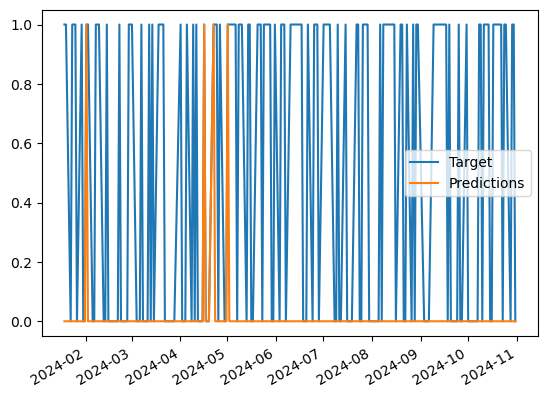

In [342]:
predictions.iloc[-200:].plot()

# Améliorations possibles

Contenu
- Comparer stocks
- Sortir une vraie série de futurs Close Price ?
- Proposer à l'utilisateur d'entrer des stocks et une quantité d'argent pour chaque et après simuler
- Plus de graphes/outils de comparaisons (recall...)
- Proposer utilisateur de varier ses choix stratégiques

Algo 
- Faire une version saved de l'algo pour sortir une "version utilisateur"
- Varier param
- Garder que la data pertinente (pas trop vieille...)

Plus de predictors
- Economic indicators
- Dividends
- External factors
- Company milestones
- Price of related stocks